# Non-Metric Space Library (NMSLIB)

In [1]:
#!pip install nmslib==2.0.6
import nmslib
import numpy as np
import time
from tqdm import tqdm
from deepface.basemodels import Facenet
from deepface.basemodels.DlibResNet import DlibResNet
from deepface.commons import functions
import os
import random
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data set

In [2]:
#Clone images from this repo: https://github.com/serengil/deepface/tree/master/tests/dataset
files = []
for r, d, f in os.walk("deepface/tests/dataset/"):
    for file in f:
        if ('.jpg' in file):
            exact_path = r + file
            files.append(exact_path)

In [3]:
model = DlibResNet()

In [4]:
target_size = (150, 150)
embedding_size = 128

In [5]:
print("Model represents ",target_size,"x3 shaped inputs to ", embedding_size," dimensional vectors")

Model represents  (150, 150) x3 shaped inputs to  128  dimensional vectors


In [6]:
embeddings = []
for index in tqdm(range(0, len(files)), desc='Finding embeddings'):
    img_path = files[index]
    img = functions.preprocess_face(img_path, target_size = target_size)
    embedding = model.predict(img)[0,:]
    embeddings.append(embedding)

Finding embeddings: 100%|██████████| 61/61 [00:33<00:00,  1.82it/s]


## Synthetic data

In [7]:
for i in tqdm(range(len(embeddings), 100000), desc='Finding embeddings'):
    key = 'deepface/tests/dataset/synthetic_%d' % (i)
    vector = [random.gauss(-0.35, 0.48) for z in range(embedding_size)]

    embeddings.append(vector)
    files.append(key)

Finding embeddings: 100%|██████████| 99939/99939 [00:13<00:00, 7489.55it/s]


## Convert embeddings to numpy

In [8]:
embeddings = np.array(embeddings)

In [9]:
print("We have ",embeddings.shape," shaped ",type(embeddings))

We have  (100000, 128)  shaped  <class 'numpy.ndarray'>


# Target

In [10]:
target_img = functions.preprocess_face("target.jpg", target_size=target_size)

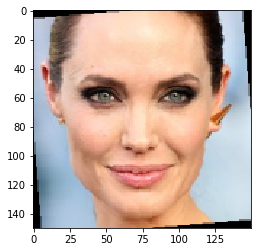

In [11]:
plt.imshow(target_img[0][:,:,::-1])

In [12]:
target_representation = model.predict(target_img)[0,:]

In [13]:
#(128,) to (1, 128)
target_representation = np.expand_dims(target_representation, axis = 0)

# NMSLIB

In [14]:
metric = 'euclidean'

if metric == 'euclidean':
    index = nmslib.init(space='l2')
elif metric == 'cosine':
    index = nmslib.init(space='cosinesimil')

In [15]:
tic = time.time()
index.addDataPointBatch(embeddings)
toc = time.time()
print("Adding data point batch lasts ",toc-tic," seconds")

Adding data point batch lasts  0.08824896812438965  seconds


In [16]:
tic = time.time()
index_time_params = {'M': 15, 'indexThreadQty': 4, 'efConstruction': 100}
index.createIndex(index_time_params) 
toc = time.time()
print("Create index lasts ",toc-tic," seconds")

Create index lasts  35.639408111572266  seconds


## Find nearest neighbors

In [17]:
tic = time.time()
neighbors, distances = index.knnQueryBatch(target_representation, k = 3, num_threads = 4)[0]
toc = time.time()
print("k-NN query batch lasts ",toc-tic," seconds")

k-NN query batch lasts  0.01203298568725586  seconds


In [18]:
neighbors

array([54, 58,  1])

1 . Target is highly correlated with  deepface/tests/dataset/img1.jpg  (Distance:  0.09903279 )


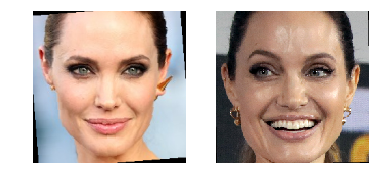

--------------------------
2 . Target is highly correlated with  deepface/tests/dataset/img10.jpg  (Distance:  0.10376522 )


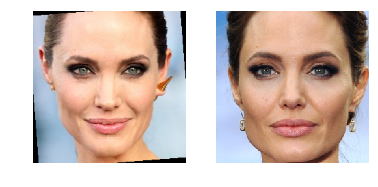

--------------------------
3 . Target is highly correlated with  deepface/tests/dataset/img11.jpg  (Distance:  0.10545211 )


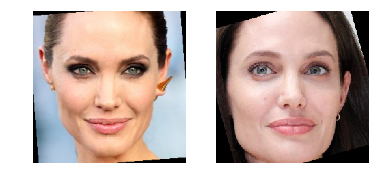

--------------------------


In [19]:
for i, value in enumerate(neighbors):
    img_path = files[i]
    distance = distances[i]
    print((i+1),". Target is highly correlated with ",img_path," (Distance: ",distance,")")
    
    fig = plt.figure()
    
    ax1 = fig.add_subplot(1,2,1)
    plt.imshow(target_img[0][:,:,::-1])
    plt.axis('off')
    
    ax1 = fig.add_subplot(1,2,2)
    img = functions.preprocess_face(img_path)[0]
    plt.imshow(img[:,:,::-1])
    plt.axis('off')
    
    plt.show()
    
    print("--------------------------")

## Save and Restore index

In [20]:
index.saveIndex('index.bin', save_data=False)

In [21]:
restored_index = nmslib.init(space='l2')
restored_index.loadIndex('index.bin')

In [22]:
restored_index.knnQueryBatch(target_representation, k = 3, num_threads = 4)

[(array([54, 58,  1]),
  array([0.09903279, 0.10376522, 0.10545211], dtype=float32))]

## Brute force

In [23]:
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [24]:
tic = time.time()
distances = []
for embedding in embeddings:
    distance = findEuclideanDistance(target_representation, embedding)
    distances.append(distance)

idx = np.argmin(distances)
print("Nearest one: ", idx)

toc = time.time()
print("Brute force method lasts ", toc-tic," seconds")

Nearest one:  54
Brute force method lasts  1.2119815349578857  seconds
